In [92]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")


import seaborn as sns
sns.set_theme()
palette = sns.color_palette("Set2")
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb

In [93]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

submission_sample = pd.read_csv('./input/sample_submission.csv')

In [94]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             371 non-null    int64  
 1   bone_length    371 non-null    float64
 2   rotting_flesh  371 non-null    float64
 3   hair_length    371 non-null    float64
 4   has_soul       371 non-null    float64
 5   color          371 non-null    object 
 6   type           371 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [96]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [97]:
train.isnull().sum()

id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64

In [98]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [99]:
test.isnull().sum()

id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
dtype: int64

In [100]:
test_indices = test['id']

test.drop('id', axis=1, inplace=True)
train.drop('id', axis=1, inplace=True)
test

,bone_length,rotting_flesh,hair_length,has_soul,color
0,0.471774,0.387937,0.706087,0.698537,black
1,0.427332,0.645024,0.565558,0.451462,white
2,0.549602,0.491931,0.660387,0.449809,black
3,0.638095,0.682867,0.471409,0.356924,white
4,0.361762,0.583997,0.377256,0.276364,black
...,...,...,...,...,...
524,0.377573,0.390158,0.696465,0.355373,blue
525,0.229161,0.601265,0.191282,0.475115,clear
526,0.510497,0.498347,0.708020,0.714154,white
527,0.331472,0.765835,0.338207,0.193431,clear


In [101]:
train = train.join(pd.get_dummies(train['color'], prefix='color', drop_first=True))
train = train.drop(columns=['color'])
train

,bone_length,rotting_flesh,hair_length,has_soul,type,color_blood,color_blue,color_clear,color_green,color_white
0,0.354512,0.350839,0.465761,0.781142,Ghoul,False,False,True,False,False
1,0.575560,0.425868,0.531401,0.439899,Goblin,False,False,False,True,False
2,0.467875,0.354330,0.811616,0.791225,Ghoul,False,False,False,False,False
3,0.776652,0.508723,0.636766,0.884464,Ghoul,False,False,False,False,False
4,0.566117,0.875862,0.418594,0.636438,Ghost,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
366,0.458132,0.391760,0.660590,0.635689,Goblin,False,True,False,False,False
367,0.331936,0.564836,0.539216,0.551471,Ghost,False,False,False,True,False
368,0.481640,0.501147,0.496446,0.544003,Ghoul,False,False,True,False,False
369,0.294943,0.771286,0.583503,0.300618,Ghost,False,False,True,False,False


In [102]:
test = test.join(pd.get_dummies(test['color'], prefix='color', drop_first=True))
test = test.drop(columns=['color'])
test

,bone_length,rotting_flesh,hair_length,has_soul,color_blood,color_blue,color_clear,color_green,color_white
0,0.471774,0.387937,0.706087,0.698537,False,False,False,False,False
1,0.427332,0.645024,0.565558,0.451462,False,False,False,False,True
2,0.549602,0.491931,0.660387,0.449809,False,False,False,False,False
3,0.638095,0.682867,0.471409,0.356924,False,False,False,False,True
4,0.361762,0.583997,0.377256,0.276364,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
524,0.377573,0.390158,0.696465,0.355373,False,True,False,False,False
525,0.229161,0.601265,0.191282,0.475115,False,False,True,False,False
526,0.510497,0.498347,0.708020,0.714154,False,False,False,False,True
527,0.331472,0.765835,0.338207,0.193431,False,False,True,False,False


In [103]:
train.columns

Index(['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'type',
       'color_blood', 'color_blue', 'color_clear', 'color_green',
       'color_white'],
      dtype='object')

<Axes: xlabel='bone_length', ylabel='has_soul'>

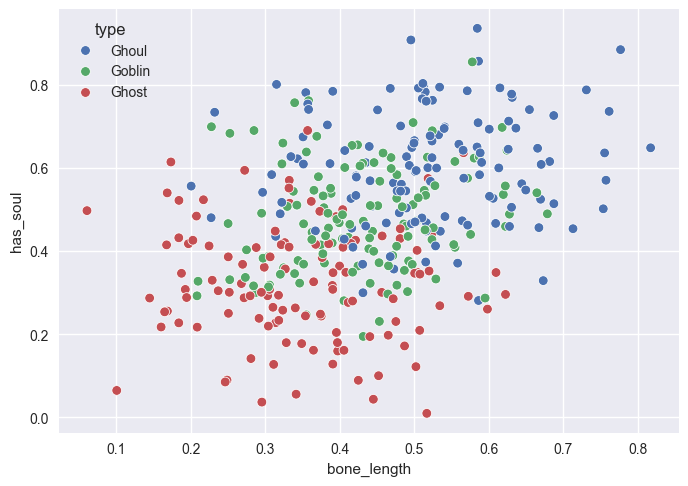

In [104]:
sns.scatterplot(data=train, x='bone_length', y='has_soul', hue='type')

<Axes: xlabel='hair_length', ylabel='has_soul'>

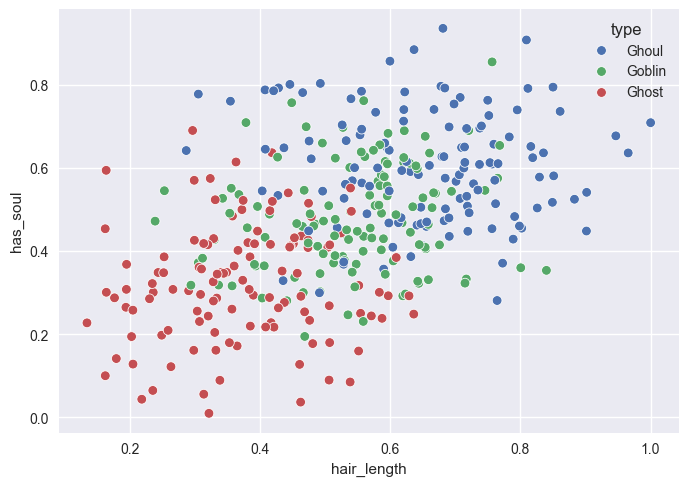

In [105]:
sns.scatterplot(data=train, x='hair_length', y='has_soul', hue='type')

<Axes: xlabel='type', ylabel='count'>

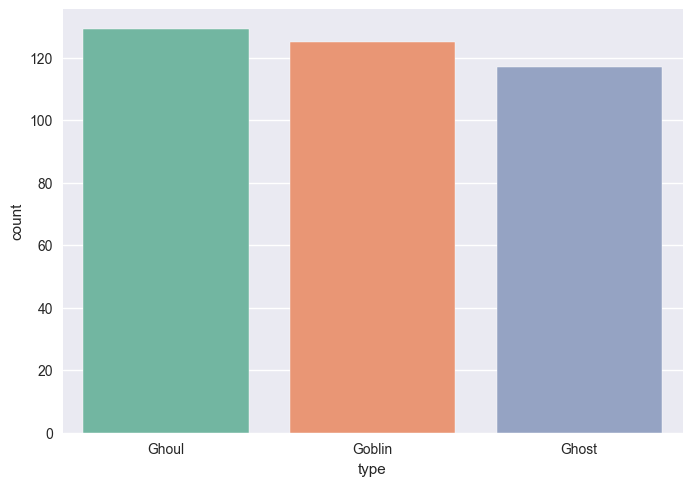

In [106]:
sns.countplot(data=train, x='type', palette=palette, legend=False)

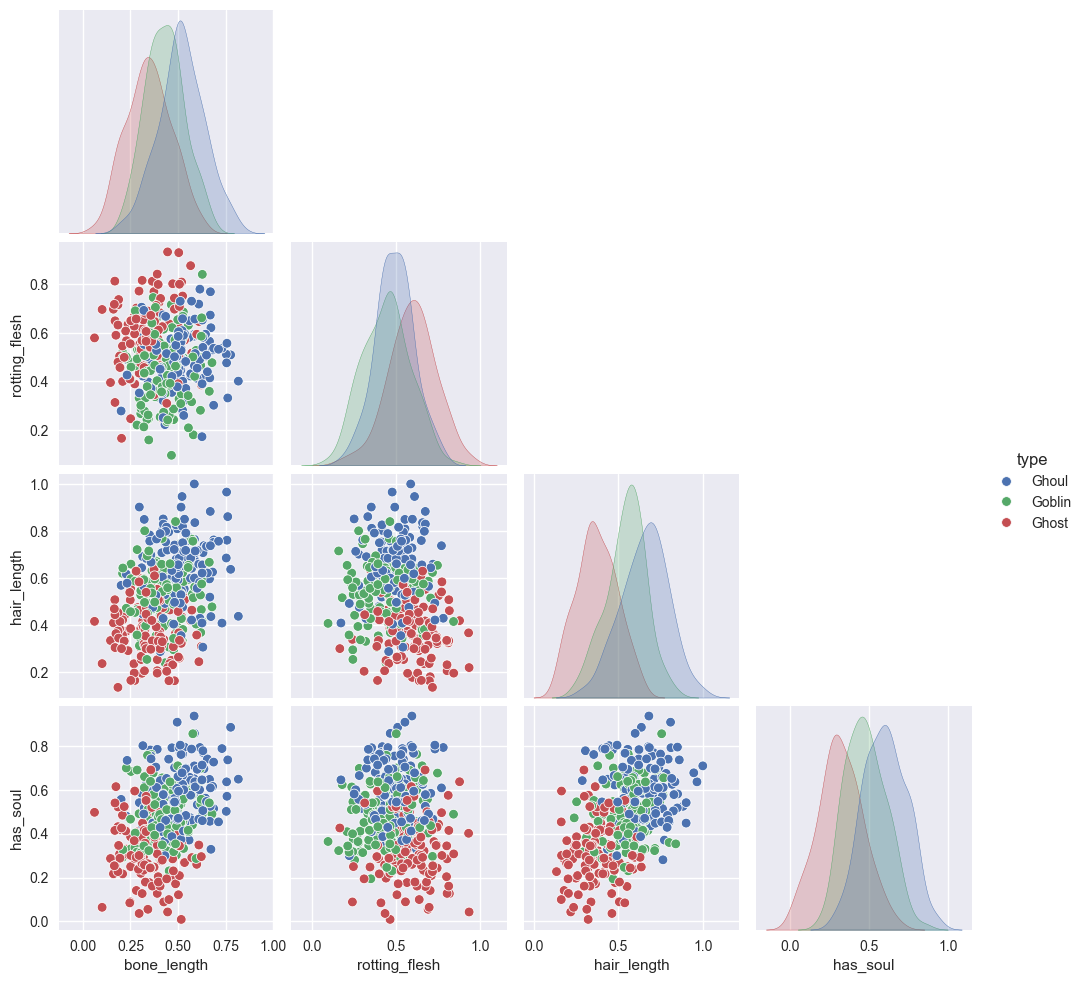

In [107]:
sns.pairplot(data=train, vars=['bone_length', 'rotting_flesh', 'hair_length', 'has_soul'], hue='type', corner=True)

<Axes: xlabel='type', ylabel='has_soul'>

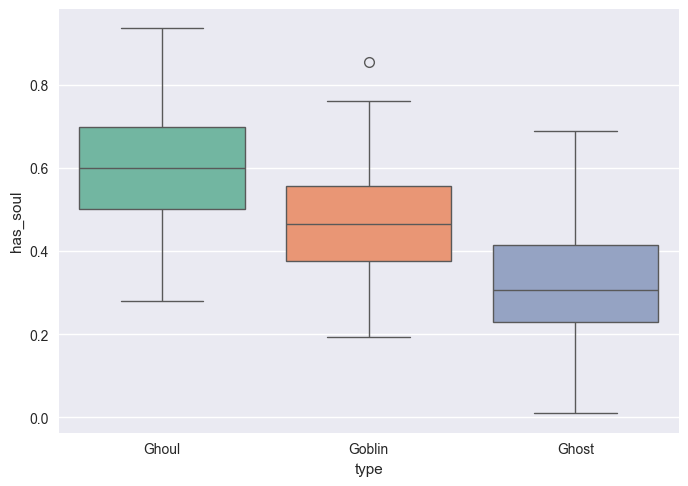

In [108]:
sns.boxplot(data=train, y='has_soul', x='type', palette=palette, legend=False)

In [109]:
trimmed_train = train.copy()

In [110]:
goblin_data = trimmed_train[trimmed_train['type'] == 'Goblin']['has_soul']
Q1 = goblin_data.quantile(0.25)
Q3 = goblin_data.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

trimmed_train.loc[(trimmed_train['type'] == 'Goblin') & (trimmed_train['has_soul'] > upper_bound), 'has_soul'] = upper_bound

<Axes: xlabel='type', ylabel='has_soul'>

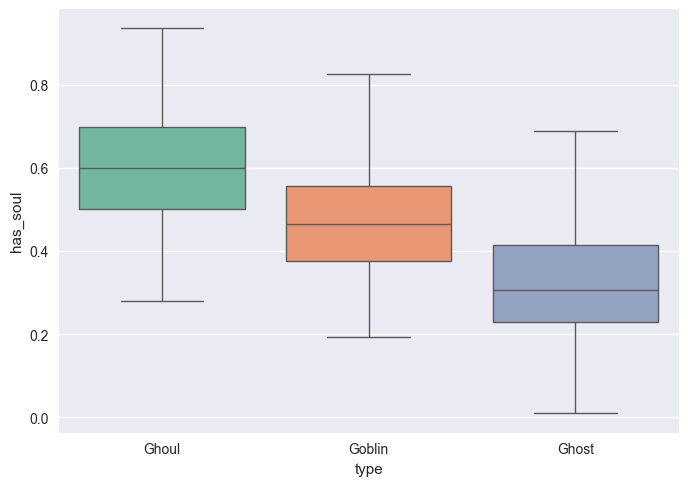

In [111]:
sns.boxplot(data=trimmed_train, y='has_soul', x='type', palette=palette, legend=False)

<Axes: xlabel='type', ylabel='bone_length'>

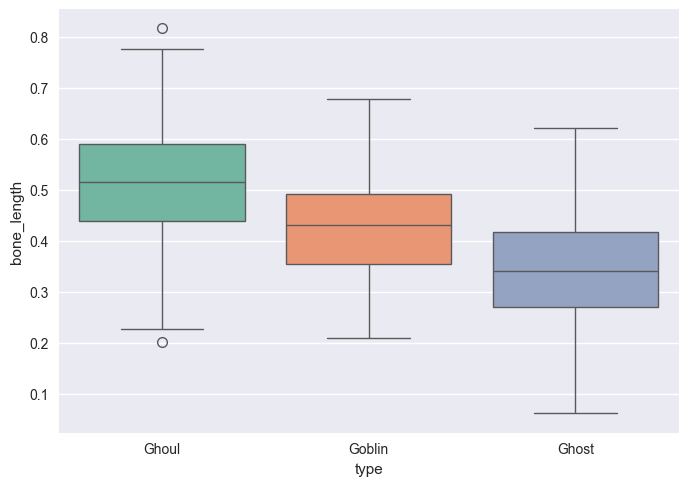

In [112]:
sns.boxplot(data=train, y='bone_length', x='type', palette=palette, legend=False)

In [113]:
ghoul_data = trimmed_train[trimmed_train['type'] == 'Ghoul']['bone_length']
Q1 = ghoul_data.quantile(0.25)  
Q3 = ghoul_data.quantile(0.75)  
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR  

trimmed_train.loc[(trimmed_train['type'] == 'Ghoul') & (trimmed_train['bone_length'] > upper_bound), 'bone_length'] = upper_bound
trimmed_train.loc[(trimmed_train['type'] == 'Ghoul') & (trimmed_train['bone_length'] < lower_bound), 'bone_length'] = lower_bound

<Axes: xlabel='type', ylabel='bone_length'>

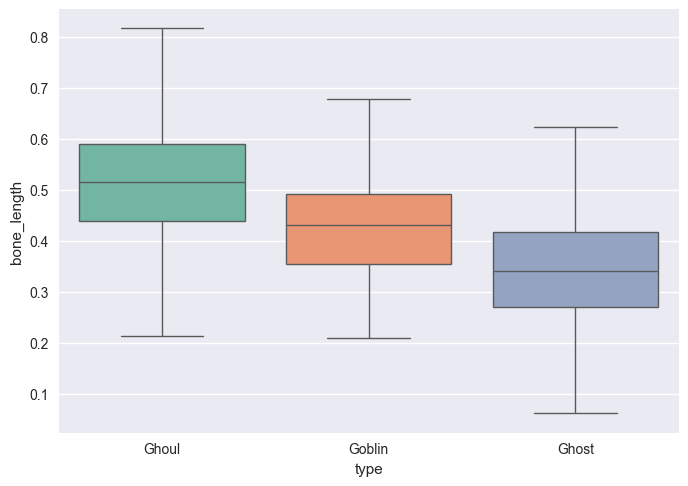

In [114]:
sns.boxplot(data=trimmed_train, y='bone_length', x='type', palette=palette, legend=False)

<Axes: xlabel='type', ylabel='hair_length'>

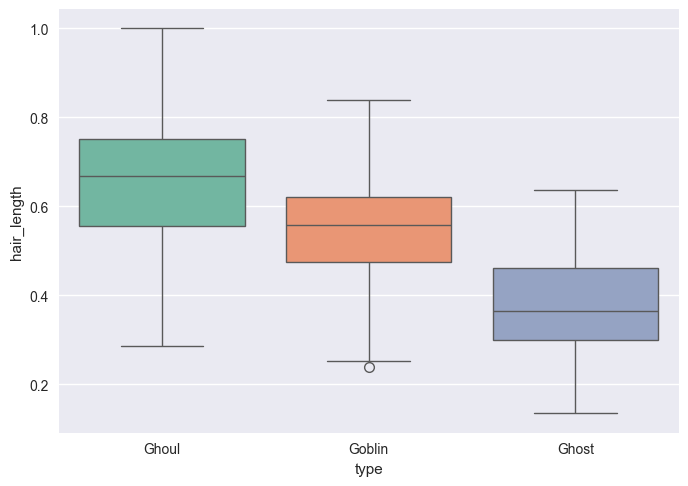

In [115]:
sns.boxplot(data=train, y='hair_length', x='type', palette=palette, legend=False)

'bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'type',
'color_blood', 'color_blue', 'color_clear', 'color_green','color_white'

In [116]:
std_trimmed_train = trimmed_train.copy()
cont_cols = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']

std_scaler = StandardScaler()

std_trimmed_train[cont_cols] = std_scaler.fit_transform(std_trimmed_train[cont_cols])
test[cont_cols] = std_scaler.transform(test[cont_cols])

<Axes: >

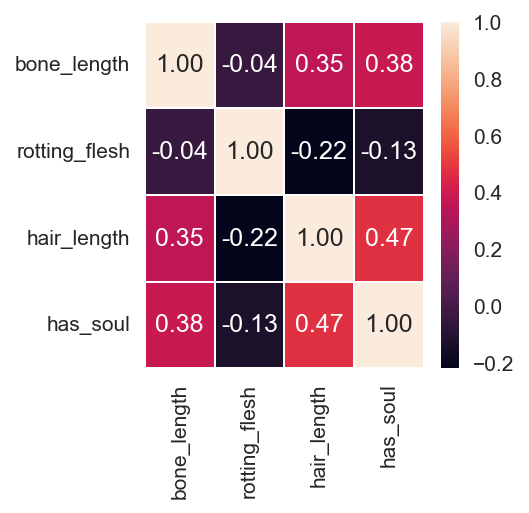

In [117]:
plt.figure(figsize=(3, 3), dpi=150)
num_features = std_trimmed_train.select_dtypes(include=['int64', 'float64'])
corr_matrix = num_features.corr()
sns.heatmap(data=corr_matrix, annot=True, fmt='.2f', linewidth=.1, )

In [118]:
X = std_trimmed_train.drop('type', axis=1)
y = std_trimmed_train['type']

In [119]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded

array([1, 2, 1, 1, 0, 2, 2, 1, 0, 0, 2, 1, 1, 2, 2, 1, 0, 1, 1, 0, 2, 1,
       2, 1, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2,
       1, 2, 1, 0, 2, 2, 1, 1, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 2,
       1, 1, 0, 1, 2, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 1,
       0, 2, 1, 0, 2, 0, 0, 2, 0, 1, 2, 2, 0, 2, 1, 0, 0, 2, 1, 1, 1, 1,
       1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 0, 1,
       0, 1, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2, 0, 0, 2, 0, 2, 0, 0, 0,
       1, 0, 2, 1, 0, 0, 1, 0, 2, 2, 0, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2,
       0, 0, 1, 1, 1, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 2, 2, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0,
       2, 2, 0, 0, 2, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 2, 1, 1, 0, 1, 0,
       2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 2, 0, 0,

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=17)

In [121]:
# let's try XGB
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 3,
    'eta': 0.1,
    'eval_metric': 'mlogloss'
}

num_round = 100

xgb_model = xgb.train(params, dtrain, num_round)

In [122]:
lgbm_model = lgb.LGBMClassifier(
    boosting_type='gbdt',  
    num_leaves=31,         
    learning_rate=0.05,    
    n_estimators=100,      
    max_depth=-1,          
    subsample=0.8,         
    colsample_bytree=0.8,
    verbose=-1  
)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, subsample=0.8,
               verbose=-1)

In [123]:
#RandomForest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=17)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=17)

In [124]:
#SVC
svc_model = SVC()

# param_grid = [
#     {  # rbf
#         'C': [0.01, 0.1, 1, 3],
#         'gamma': ['scale', 1, 0.1, 0.01],
#         'kernel': ['rbf']
#     },
#     {  # lin
#         'C': [0.01, 0.1, 1, 3],
#         'kernel': ['linear']
#     },
#     {  # poly
#         'C': [0.01, 0.1, 1],
#         'gamma': ['scale', 1, 0.1, 0.01],
#         'kernel': ['poly'],
#         'degree': [2, 3]
#     }
# ]
param_grid = {
        'C': [0.05],
        'kernel': ['linear']
}

grid_svc = GridSearchCV(svc_model, param_grid=param_grid)
grid_svc.fit(X_train, y_train)
grid_svc.best_params_

{'C': 0.05, 'kernel': 'linear'}

In [125]:
#GradientBoosting
param_grid = {
    'n_estimators': [200],              
    'learning_rate': [0.01],          
    'max_depth': [5],                       
    'subsample': [1.0],                      
    'min_samples_split': [10]
}

gb_model = GradientBoostingClassifier()
gb_grid = GridSearchCV(gb_model, param_grid)
gb_grid.fit(X_train, y_train)
gb_grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'min_samples_split': 10,
 'n_estimators': 200,
 'subsample': 1.0}

In [126]:
xgb_pred = xgb_model.predict(dtest)
lgbm_pred = lgbm_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
svc_pred = grid_svc.predict(X_test)
gb_pred = gb_grid.predict(X_test)

accuracy_xgb = accuracy_score(y_test, xgb_pred)
accuracy_lgbm = accuracy_score(y_test, lgbm_pred)
accuracy_rf = accuracy_score(y_test, rf_pred)
accuracy_svc = accuracy_score(y_test, svc_pred)
accuracy_gb = accuracy_score(y_test, gb_pred)

print(f'xgb accuracy: {accuracy_xgb}')
print(f'lgbm accuracy: {accuracy_lgbm}')
print(f'rf accuracy: {accuracy_rf}')
print(f'svc accuracy: {accuracy_svc}')
print(f'gb accuracy: {accuracy_gb}')

xgb accuracy: 0.75
lgbm accuracy: 0.7053571428571429
rf accuracy: 0.7232142857142857
svc accuracy: 0.7410714285714286
gb accuracy: 0.7321428571428571


In [127]:
confusion_matrix(y_test, xgb_pred)

array([[31,  0,  3],
       [ 1, 29, 11],
       [ 6,  7, 24]], dtype=int64)

In [128]:
test

,bone_length,rotting_flesh,hair_length,has_soul,color_blood,color_blue,color_clear,color_green,color_white
0,0.283438,-0.813568,1.043022,1.292976,False,False,False,False,False
1,-0.051743,0.945366,0.214788,-0.112986,False,False,False,False,True
2,0.870410,-0.102066,0.773685,-0.122389,False,False,False,False,False
3,1.537822,1.204286,-0.340098,-0.650941,False,False,False,False,True
4,-0.546270,0.527837,-0.895004,-1.109363,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
524,-0.427029,-0.798374,0.986314,-0.659768,False,True,False,False,False
525,-1.546342,0.645977,-1.991081,0.021612,False,False,True,False,False
526,0.575485,-0.058162,1.054416,1.381840,False,False,False,False,True
527,-0.774717,1.771931,-1.125153,-1.581286,False,False,True,False,False


In [129]:
submission_sample

,id,type
0,3,Ghost
1,6,Ghost
2,9,Ghost
3,10,Ghost
4,13,Ghost
...,...,...
524,893,Ghost
525,894,Ghost
526,895,Ghost
527,898,Ghost


In [130]:
test_dmatrix = xgb.DMatrix(test)

float_pred = xgb_model.predict(test_dmatrix)
int_pred = np.round(float_pred).astype(int)
int_pred

array([1, 2, 1, 1, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 0, 0, 1, 1, 1,
       2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 0, 1, 2, 2, 2, 1,
       2, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1,
       0, 2, 0, 2, 1, 0, 0, 2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2,
       2, 1, 2, 2, 1, 2, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1,
       2, 0, 1, 1, 0, 1, 1, 2, 1, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2, 2, 1, 0, 1, 2,
       2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 1, 2, 2, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 2, 0, 2,
       1, 1, 2, 1, 2, 0, 1, 1, 0, 2, 1, 1, 2, 1, 2, 0, 0, 2, 1, 1, 1, 1,
       2, 1, 0, 0, 1, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2,

In [131]:
final_pred = encoder.inverse_transform(int_pred.astype(int))

In [134]:
submission = pd.DataFrame({'id': test_indices, 'type': final_pred})
submission

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghoul
4,13,Ghost
...,...,...
524,893,Goblin
525,894,Ghost
526,895,Ghoul
527,898,Ghost


In [133]:
submission.to_csv('./output/submission.csv', index=False)